# Compare surface elevation along transects

Author: Ziqi Yin

Last modified: 2024 Jul 24

Table of contents:
* [Plot the surface elevation at different time along transects K, S.](#first-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

import pyproj

In [2]:
## Parameter
g = 9.80616 #[m/s2]

In [3]:
## Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Get data

#### Transect

In [12]:
# K transect
kfile = xr.open_dataset(home_dir+'data/ktransect-elev.nc')
klon = kfile.klon
klat = kfile.klat
kdist = kfile.kdist
kzraw = kfile.zraw
kzsims = kfile.zsims

In [13]:
# S transect
sfile = xr.open_dataset(home_dir+'data/stransect-elev.nc')
slon = sfile.slon
slat = sfile.slat
sdist = sfile.sdist
szraw = sfile.zraw
szsims = sfile.zsims

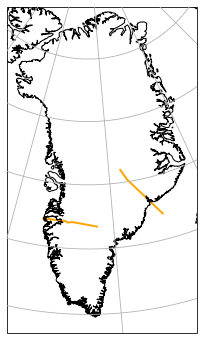

In [6]:
# Flowline position
fig = plt.figure(figsize = (4,6))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad'] =14

ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.5, -29.5, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)
ax1.gridlines(zorder=8)

plt.plot(klon, klat, color='orange', linewidth=2, transform = crs_ll);
plt.plot(slon, slat, color='orange', linewidth=2, transform = crs_ll);

#### CAM PHIS

In [14]:
## BG iteration 7
BG7_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PHIS_JJA_yearly.nc')['PHIS'] #surface geopotential [m2/s2]
f09_lon = BG7_PHIS_JJA_yearly.lon
f09_lat = BG7_PHIS_JJA_yearly.lat

In [15]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140,:,:]

# 4xext
f09_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [16]:
## f09nohacks
# piControl
f09_nohacks_piControl_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PHIS_piControl_JJA_yearly.nc')['PHIS']

# 1pctCO2
f09_nohacks_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
f09_nohacks_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

In [17]:
## Arctic grid
# piControl
ARCTIC_piControl_p4_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_piControl_p4_JJA_yearly.nc')['PHIS']
ARCTIC_lat = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lat.nc')['lat']
ARCTIC_lon = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lon.nc')['lon']

# 1pctCO2
ARCTIC_1pctCO2_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
ARCTIC_4xext_PHIS_JJA_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

#### CISM topg and thk

In [18]:
ARCTIC_piControl_p4_thk_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_thk_piControl_p4_yearly.nc')['thk']
cism_x1 = ARCTIC_piControl_p4_thk_yearly.x1
cism_y1 = ARCTIC_piControl_p4_thk_yearly.y1
ARCTIC_piControl_p4_topg_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_topg_piControl_p4_yearly.nc')['topg']

#### Mask

In [20]:
# f09
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'dynamic_GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]

#ARCTIC
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]

## Calculate

In [ ]:
# Concat 1pctCO2 and 4xext periods
f09_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_1pctCO2_PHIS_JJA_yearly, f09_4xext_PHIS_JJA_yearly], dim='time')

f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_JJA_yearly, f09_nohacks_4xext_PHIS_JJA_yearly], dim='time')

ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_JJA_yearly, ARCTIC_4xext_PHIS_JJA_yearly], dim='time')

In [13]:
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_PHIS_PI = BG7_PHIS_JJA_yearly[148,:,:]

f09_nohacks_PHIS_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-1,:]

# CO2 stabilization (year 150)
f09_PHIS_stab = f09_1pctCO2_4xext_PHIS_JJA_yearly[149,:,:]

f09_nohacks_PHIS_stab = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[149,:,:]

ARCTIC_PHIS_stab = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[149,:]

# CO2 stabilization (year 250)
f09_PHIS_mid = f09_1pctCO2_4xext_PHIS_JJA_yearly[249,:,:]

f09_nohacks_PHIS_mid = f09_nohacks_1pctCO2_4xext_PHIS_JJA_yearly[249,:,:]

ARCTIC_PHIS_mid = ARCTIC_1pctCO2_4xext_PHIS_JJA_yearly[249,:]

# end of simulation (year 350)
f09_PHIS_end = f09_4xext_PHIS_JJA_yearly[-1,:,:]

f09_nohacks_PHIS_end = f09_nohacks_4xext_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_end = ARCTIC_4xext_PHIS_JJA_yearly[-1,:]

In [23]:
## Temporary
## Select (JJA mean is the same to annual mean)
# end of PI (year 0)
f09_PHIS_PI = BG7_PHIS_JJA_yearly[148,:,:]

f09_nohacks_PHIS_PI = f09_nohacks_piControl_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_PI = ARCTIC_piControl_p4_PHIS_JJA_yearly[-1,:]

# CO2 stabilization (year 150)
f09_PHIS_stab = f09_4xext_PHIS_JJA_yearly[9,:,:]

f09_nohacks_PHIS_stab = f09_nohacks_4xext_PHIS_JJA_yearly[9,:,:]

ARCTIC_PHIS_stab = ARCTIC_4xext_PHIS_JJA_yearly[9,:]

# CO2 stabilization (year 250)
f09_PHIS_mid = f09_4xext_PHIS_JJA_yearly[109,:,:]

f09_nohacks_PHIS_mid = f09_nohacks_4xext_PHIS_JJA_yearly[109,:,:]

ARCTIC_PHIS_mid = ARCTIC_4xext_PHIS_JJA_yearly[109,:]

# end of simulation (year 350)
f09_PHIS_end = f09_4xext_PHIS_JJA_yearly[-1,:,:]

f09_nohacks_PHIS_end = f09_nohacks_4xext_PHIS_JJA_yearly[-1,:,:]

ARCTIC_PHIS_end = ARCTIC_4xext_PHIS_JJA_yearly[-1,:]

In [24]:
## Glacier frac
# end of PI (year 0)
f09_glacier_frac_PI = BG7_glacier_frac[148,:,:]

f09_nohacks_glacier_frac_PI = f09_nohacks_glacier_frac_piControl[-1,:,:]

ARCTIC_glacier_frac_PI = ARCTIC_glacier_frac_piControl_p4[-1,:]

# CO2 stabilization (year 150)
f09_glacier_frac_stab = f09_glacier_frac_4xext[9,:,:]

f09_nohacks_glacier_frac_stab = f09_nohacks_glacier_frac_4xext[9,:,:]

ARCTIC_glacier_frac_stab = ARCTIC_glacier_frac_4xext[9,:]

# CO2 stabilization (year 250)
f09_glacier_frac_mid = f09_glacier_frac_4xext[109,:,:]

f09_nohacks_glacier_frac_mid = f09_nohacks_glacier_frac_4xext[109,:,:]

ARCTIC_glacier_frac_mid = ARCTIC_glacier_frac_4xext[109,:]

# end of simulation (year 350)
f09_glacier_frac_end = f09_glacier_frac_4xext[-1,:,:]

f09_nohacks_glacier_frac_end = f09_nohacks_glacier_frac_4xext[-1,:,:]

ARCTIC_glacier_frac_end = ARCTIC_glacier_frac_4xext[-1,:]

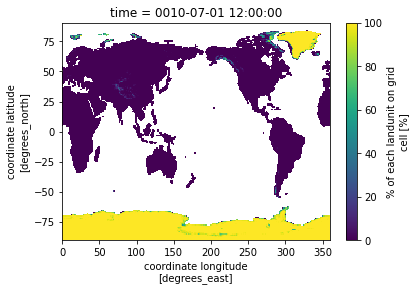

In [26]:
f09_nohacks_glacier_frac_stab.plot();

## Interp

In [27]:
## K transect
# f09
f09_PHIS_PI_Kt = kdist * 0
f09_PHIS_stab_Kt = kdist * 0
f09_PHIS_mid_Kt = kdist * 0
f09_PHIS_end_Kt = kdist * 0

for i in range(len(kdist)):
    f09_PHIS_PI_Kt[i] = f09_PHIS_PI.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_PHIS_stab_Kt[i] = f09_PHIS_stab.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_PHIS_mid_Kt[i] = f09_PHIS_mid.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_PHIS_end_Kt[i] = f09_PHIS_end.interp(lat=klat[i], lon=klon[i], method='nearest')

# f09 nohacks
f09_nohacks_PHIS_PI_Kt = kdist * 0
f09_nohacks_PHIS_stab_Kt = kdist * 0
f09_nohacks_PHIS_mid_Kt = kdist * 0
f09_nohacks_PHIS_end_Kt = kdist * 0

for i in range(len(kdist)):
    f09_nohacks_PHIS_PI_Kt[i] = f09_nohacks_PHIS_PI.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_PHIS_stab_Kt[i] = f09_nohacks_PHIS_stab.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_PHIS_mid_Kt[i] = f09_nohacks_PHIS_mid.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_PHIS_end_Kt[i] = f09_nohacks_PHIS_end.interp(lat=klat[i], lon=klon[i], method='nearest')

In [28]:
## S transect
# f09
f09_PHIS_PI_St = sdist * 0
f09_PHIS_stab_St = sdist * 0
f09_PHIS_mid_St = sdist * 0
f09_PHIS_end_St = sdist * 0

for i in range(len(sdist)):
    f09_PHIS_PI_St[i] = f09_PHIS_PI.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_PHIS_stab_St[i] = f09_PHIS_stab.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_PHIS_mid_St[i] = f09_PHIS_mid.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_PHIS_end_St[i] = f09_PHIS_end.interp(lat=slat[i], lon=slon[i], method='nearest')

# f09 nohacks
f09_nohacks_PHIS_PI_St = sdist * 0
f09_nohacks_PHIS_stab_St = sdist * 0
f09_nohacks_PHIS_mid_St = sdist * 0
f09_nohacks_PHIS_end_St = sdist * 0

for i in range(len(kdist)):
    f09_nohacks_PHIS_PI_St[i] = f09_nohacks_PHIS_PI.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_PHIS_stab_St[i] = f09_nohacks_PHIS_stab.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_PHIS_mid_St[i] = f09_nohacks_PHIS_mid.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_PHIS_end_St[i] = f09_nohacks_PHIS_end.interp(lat=slat[i], lon=slon[i], method='nearest')

In [29]:
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [30]:
# For ARCTIC K transect, masked the vars
ARCTIC_lat_Ksel = ARCTIC_lat.where((ARCTIC_lat>=66)&(ARCTIC_lat<=67.5)).where((ARCTIC_lon>=305.5)&(ARCTIC_lon<=317)).dropna(dim='ncol')
ARCTIC_lon_Ksel = ARCTIC_lon.where((ARCTIC_lat>=66)&(ARCTIC_lat<=67.5)).where((ARCTIC_lon>=305.5)&(ARCTIC_lon<=317)).dropna(dim='ncol')
ARCTIC_PHIS_PI_Ksel = ARCTIC_PHIS_PI.where((ARCTIC_lat>=66)&(ARCTIC_lat<=67.5)).where((ARCTIC_lon>=305.5)&(ARCTIC_lon<=317)).dropna(dim='ncol')
ARCTIC_PHIS_stab_Ksel = ARCTIC_PHIS_stab.where((ARCTIC_lat>=66)&(ARCTIC_lat<=67.5)).where((ARCTIC_lon>=305.5)&(ARCTIC_lon<=317)).dropna(dim='ncol')
ARCTIC_PHIS_mid_Ksel = ARCTIC_PHIS_mid.where((ARCTIC_lat>=66)&(ARCTIC_lat<=67.5)).where((ARCTIC_lon>=305.5)&(ARCTIC_lon<=317)).dropna(dim='ncol')
ARCTIC_PHIS_end_Ksel = ARCTIC_PHIS_end.where((ARCTIC_lat>=66)&(ARCTIC_lat<=67.5)).where((ARCTIC_lon>=305.5)&(ARCTIC_lon<=317)).dropna(dim='ncol')

In [31]:
## K transect
# PI
ARCTIC_PHIS_PI_Kt = kdist * 0
ARCTIC_PI_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_PI_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_PHIS_PI_Kt[i] = ARCTIC_PHIS_PI_Ksel[ARCTIC_PI_Ksel_dist.argmin()]

# stab
ARCTIC_PHIS_stab_Kt = kdist * 0
ARCTIC_stab_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_stab_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_PHIS_stab_Kt[i] = ARCTIC_PHIS_stab_Ksel[ARCTIC_stab_Ksel_dist.argmin()]

# mid
ARCTIC_PHIS_mid_Kt = kdist * 0
ARCTIC_mid_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_mid_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_PHIS_mid_Kt[i] = ARCTIC_PHIS_mid_Ksel[ARCTIC_mid_Ksel_dist.argmin()]

# end
ARCTIC_PHIS_end_Kt = kdist * 0
ARCTIC_end_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_end_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_PHIS_end_Kt[i] = ARCTIC_PHIS_end_Ksel[ARCTIC_end_Ksel_dist.argmin()]

In [32]:
# For ARCTIC S transect, masked the vars
ARCTIC_lat_Ssel = ARCTIC_lat.where((ARCTIC_lat>=66.5)&(ARCTIC_lat<=71.5)).where((ARCTIC_lon>=322)&(ARCTIC_lon<=330.5)).dropna(dim='ncol')
ARCTIC_lon_Ssel = ARCTIC_lon.where((ARCTIC_lat>=66.5)&(ARCTIC_lat<=71.5)).where((ARCTIC_lon>=322)&(ARCTIC_lon<=330.5)).dropna(dim='ncol')
ARCTIC_PHIS_PI_Ssel = ARCTIC_PHIS_PI.where((ARCTIC_lat>=66.5)&(ARCTIC_lat<=71.5)).where((ARCTIC_lon>=322)&(ARCTIC_lon<=330.5)).dropna(dim='ncol')
ARCTIC_PHIS_stab_Ssel = ARCTIC_PHIS_stab.where((ARCTIC_lat>=66.5)&(ARCTIC_lat<=71.5)).where((ARCTIC_lon>=322)&(ARCTIC_lon<=330.5)).dropna(dim='ncol')
ARCTIC_PHIS_mid_Ssel = ARCTIC_PHIS_mid.where((ARCTIC_lat>=66.5)&(ARCTIC_lat<=71.5)).where((ARCTIC_lon>=322)&(ARCTIC_lon<=330.5)).dropna(dim='ncol')
ARCTIC_PHIS_end_Ssel = ARCTIC_PHIS_end.where((ARCTIC_lat>=66.5)&(ARCTIC_lat<=71.5)).where((ARCTIC_lon>=322)&(ARCTIC_lon<=330.5)).dropna(dim='ncol')

In [33]:
## S transect
# PI
ARCTIC_PHIS_PI_St = sdist * 0
ARCTIC_PI_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_PI_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_PHIS_PI_St[i] = ARCTIC_PHIS_PI_Ssel[ARCTIC_PI_Ssel_dist.argmin()]

# stab
ARCTIC_PHIS_stab_St = sdist * 0
ARCTIC_stab_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_stab_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_PHIS_stab_St[i] = ARCTIC_PHIS_stab_Ssel[ARCTIC_stab_Ssel_dist.argmin()]

# mid
ARCTIC_PHIS_mid_St = sdist * 0
ARCTIC_mid_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_mid_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_PHIS_mid_St[i] = ARCTIC_PHIS_mid_Ssel[ARCTIC_mid_Ssel_dist.argmin()]

# end
ARCTIC_PHIS_end_St = sdist * 0
ARCTIC_end_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_end_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_PHIS_end_St[i] = ARCTIC_PHIS_end_Ssel[ARCTIC_end_Ssel_dist.argmin()]

#### CISM topg and thk

In [34]:
# Convert lat/lon to polar stereographic projection coordinates used by CISM

projIn = pyproj.Proj(init='epsg:4326')

projOut = pyproj.Proj('+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs',
                      preserve_units=True)

x_k, y_k = pyproj.transform(projIn, projOut, klon, klat)
x_s, y_s = pyproj.transform(projIn, projOut, slon, slat)

In [35]:
# year 0
ARCTIC_topg_yearly_0_k = np.zeros(len(x_k))
ARCTIC_thk_yearly_0_k = np.zeros(len(x_k))

for i in range(len(x_k)):
    ARCTIC_topg_yearly_0_k[i] = ARCTIC_piControl_p4_topg_yearly[-1,:,:].interp(x1=x_k[i], y1=y_k[i], method='linear')
    ARCTIC_thk_yearly_0_k[i] = ARCTIC_piControl_p4_thk_yearly[-1,:,:].interp(x1=x_k[i], y1=y_k[i], method='linear')

In [36]:
# year 0
ARCTIC_topg_yearly_0_s = np.zeros(len(x_s))
ARCTIC_thk_yearly_0_s = np.zeros(len(x_s))

for i in range(len(x_s)):
    ARCTIC_topg_yearly_0_s[i] = ARCTIC_piControl_p4_topg_yearly[-1,:,:].interp(x1=x_s[i], y1=y_s[i], method='linear')
    ARCTIC_thk_yearly_0_s[i] = ARCTIC_piControl_p4_thk_yearly[-1,:,:].interp(x1=x_s[i], y1=y_s[i], method='linear')

#### Glacier frac

In [88]:
## K transect
# f09
f09_glacier_frac_PI_Kt = kdist * 0
f09_glacier_frac_stab_Kt = kdist * 0
f09_glacier_frac_mid_Kt = kdist * 0
f09_glacier_frac_end_Kt = kdist * 0

for i in range(len(kdist)):
    f09_glacier_frac_PI_Kt[i] = f09_glacier_frac_PI.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_glacier_frac_stab_Kt[i] = f09_glacier_frac_stab.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_glacier_frac_mid_Kt[i] = f09_glacier_frac_mid.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_glacier_frac_end_Kt[i] = f09_glacier_frac_end.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')

# f09 nohacks
f09_nohacks_glacier_frac_PI_Kt = kdist * 0
f09_nohacks_glacier_frac_stab_Kt = kdist * 0
f09_nohacks_glacier_frac_mid_Kt = kdist * 0
f09_nohacks_glacier_frac_end_Kt = kdist * 0

for i in range(len(kdist)):
    f09_nohacks_glacier_frac_PI_Kt[i] = f09_nohacks_glacier_frac_PI.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_glacier_frac_stab_Kt[i] = f09_nohacks_glacier_frac_stab.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_glacier_frac_mid_Kt[i] = f09_nohacks_glacier_frac_mid.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_glacier_frac_end_Kt[i] = f09_nohacks_glacier_frac_end.fillna(0).interp(lat=klat[i], lon=klon[i], method='nearest')

In [86]:
## S transect
# f09
f09_glacier_frac_PI_St = sdist * 0
f09_glacier_frac_stab_St = sdist * 0
f09_glacier_frac_mid_St = sdist * 0
f09_glacier_frac_end_St = sdist * 0

for i in range(len(sdist)):
    f09_glacier_frac_PI_St[i] = f09_glacier_frac_PI.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_glacier_frac_stab_St[i] = f09_glacier_frac_stab.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_glacier_frac_mid_St[i] = f09_glacier_frac_mid.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_glacier_frac_end_St[i] = f09_glacier_frac_end.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')

# f09 nohacks
f09_nohacks_glacier_frac_PI_St = sdist * 0
f09_nohacks_glacier_frac_stab_St = sdist * 0
f09_nohacks_glacier_frac_mid_St = sdist * 0
f09_nohacks_glacier_frac_end_St = sdist * 0

for i in range(len(sdist)):
    f09_nohacks_glacier_frac_PI_St[i] = f09_nohacks_glacier_frac_PI.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_glacier_frac_stab_St[i] = f09_nohacks_glacier_frac_stab.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_glacier_frac_mid_St[i] = f09_nohacks_glacier_frac_mid.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_glacier_frac_end_St[i] = f09_nohacks_glacier_frac_end.fillna(0).interp(lat=slat[i], lon=slon[i], method='nearest')

In [77]:
# For ARCTIC K transect, masked the vars
# Since there are nan values in glacier_frac, so directly dropna() will result in different length of array to ARCTIC_lat/lon_Ksel
ARCTIC_lat_Ksel = ARCTIC_lat.where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='ncol')
ARCTIC_lon_Ksel = ARCTIC_lon.where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='ncol')
ARCTIC_glacier_frac_PI_Ksel = ARCTIC_glacier_frac_PI.fillna(0).where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')
ARCTIC_glacier_frac_stab_Ksel = ARCTIC_glacier_frac_stab.fillna(0).where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')
ARCTIC_glacier_frac_mid_Ksel = ARCTIC_glacier_frac_mid.fillna(0).where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')
ARCTIC_glacier_frac_end_Ksel = ARCTIC_glacier_frac_end.fillna(0).where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')

In [79]:
## K transect
# PI
ARCTIC_glacier_frac_PI_Kt = kdist * 0
ARCTIC_PI_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_PI_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_glacier_frac_PI_Kt[i] = ARCTIC_glacier_frac_PI_Ksel[ARCTIC_PI_Ksel_dist.argmin()]

# stab
ARCTIC_glacier_frac_stab_Kt = kdist * 0
ARCTIC_stab_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_stab_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_glacier_frac_stab_Kt[i] = ARCTIC_glacier_frac_stab_Ksel[ARCTIC_stab_Ksel_dist.argmin()]

# mid
ARCTIC_glacier_frac_mid_Kt = kdist * 0
ARCTIC_mid_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_mid_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_glacier_frac_mid_Kt[i] = ARCTIC_glacier_frac_mid_Ksel[ARCTIC_mid_Ksel_dist.argmin()]

# end
ARCTIC_glacier_frac_end_Kt = kdist * 0
ARCTIC_end_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_end_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_glacier_frac_end_Kt[i] = ARCTIC_glacier_frac_end_Ksel[ARCTIC_end_Ksel_dist.argmin()]

In [83]:
# For ARCTIC S transect, masked the vars
ARCTIC_lat_Ssel = ARCTIC_lat.where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='ncol')
ARCTIC_lon_Ssel = ARCTIC_lon.where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='ncol')
ARCTIC_glacier_frac_PI_Ssel = ARCTIC_glacier_frac_PI.fillna(0).where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')
ARCTIC_glacier_frac_stab_Ssel = ARCTIC_glacier_frac_stab.fillna(0).where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')
ARCTIC_glacier_frac_mid_Ssel = ARCTIC_glacier_frac_mid.fillna(0).where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')
ARCTIC_glacier_frac_end_Ssel = ARCTIC_glacier_frac_end.fillna(0).where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')

In [84]:
## S transect
# PI
ARCTIC_glacier_frac_PI_St = sdist * 0
ARCTIC_PI_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_PI_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_glacier_frac_PI_St[i] = ARCTIC_glacier_frac_PI_Ssel[ARCTIC_PI_Ssel_dist.argmin()]

# stab
ARCTIC_glacier_frac_stab_St = sdist * 0
ARCTIC_stab_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_stab_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_glacier_frac_stab_St[i] = ARCTIC_glacier_frac_stab_Ssel[ARCTIC_stab_Ssel_dist.argmin()]

# mid
ARCTIC_glacier_frac_mid_St = sdist * 0
ARCTIC_mid_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_mid_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_glacier_frac_mid_St[i] = ARCTIC_glacier_frac_mid_Ssel[ARCTIC_mid_Ssel_dist.argmin()]

# end
ARCTIC_glacier_frac_end_St = sdist * 0
ARCTIC_end_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_end_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_glacier_frac_end_St[i] = ARCTIC_glacier_frac_end_Ssel[ARCTIC_end_Ssel_dist.argmin()]

## Plot

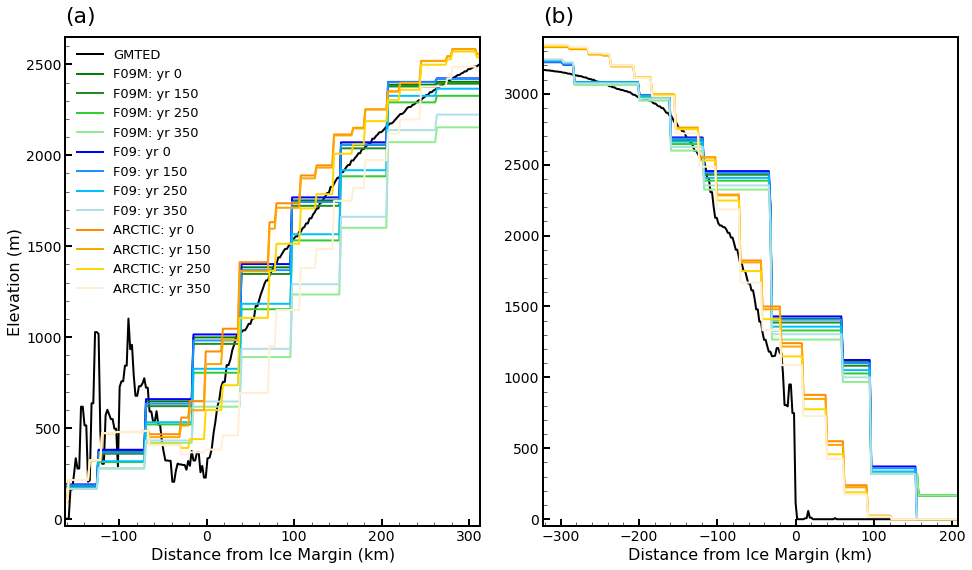

In [24]:
fig = plt.figure(figsize = (16,9))
gs=GridSpec(1,2)
plt.rcParams['axes.titlepad'] = 14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

#-------------------------------------num1-------------------------------------
ax1 = plt.subplot(gs[0])

plt.plot(kdist, kzraw, color='k', linewidth=2, label='GMTED')
plt.plot(kdist, f09_PHIS_PI_Kt/g, color='green', linewidth=2, label='F09M: yr 0')
plt.plot(kdist, f09_PHIS_stab_Kt/g, color='forestgreen', linewidth=2, label='F09M: yr 150')
plt.plot(kdist, f09_PHIS_mid_Kt/g, color='limegreen', linewidth=2, label='F09M: yr 250')
plt.plot(kdist, f09_PHIS_end_Kt/g, color='lightgreen', linewidth=2, label='F09M: yr 350')

plt.plot(kdist, f09_nohacks_PHIS_PI_Kt/g, color='blue', linewidth=2, label='F09: yr 0')
plt.plot(kdist, f09_nohacks_PHIS_stab_Kt/g, color='dodgerblue', linewidth=2, label='F09: yr 150')
plt.plot(kdist, f09_nohacks_PHIS_mid_Kt/g, color='deepskyblue', linewidth=2, label='F09: yr 250')
plt.plot(kdist, f09_nohacks_PHIS_end_Kt/g, color='powderblue', linewidth=2, label='F09: yr 350')

plt.plot(kdist, ARCTIC_PHIS_PI_Kt/g, color='darkorange', linewidth=2, label='ARCTIC: yr 0')
plt.plot(kdist, ARCTIC_PHIS_stab_Kt/g, color='orange', linewidth=2, label='ARCTIC: yr 150')
plt.plot(kdist, ARCTIC_PHIS_mid_Kt/g, color='gold', linewidth=2, label='ARCTIC: yr 250')
plt.plot(kdist, ARCTIC_PHIS_end_Kt/g, color='papayawhip', linewidth=2, label='ARCTIC: yr 350')

ax1.set_xlim([kdist[0], kdist[-1]])
ax1.set_ylim([-40, 2650])
ax1.set_xlabel('Distance from Ice Margin (km)', fontsize = 16)
ax1.set_ylabel('Elevation (m)', fontsize = 16)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")
ax1.tick_params(labelsize=14)
plt.title('(a)', fontsize=22, loc='left')

ax1.legend(loc = 'best', frameon = False, prop={'size':13})

#-------------------------------------num2-------------------------------------
ax2 = plt.subplot(gs[1])

plt.plot(sdist, szraw, color='k', linewidth=2, label='GMTED')
plt.plot(sdist, f09_PHIS_PI_St/g, color='green', linewidth=2, label='F09M: yr 0')
plt.plot(sdist, f09_PHIS_stab_St/g, color='forestgreen', linewidth=2, label='F09M: yr 150')
plt.plot(sdist, f09_PHIS_mid_St/g, color='limegreen', linewidth=2, label='F09M: yr 250')
plt.plot(sdist, f09_PHIS_end_St/g, color='lightgreen', linewidth=2, label='F09M: yr 350')

plt.plot(sdist, f09_nohacks_PHIS_PI_St/g, color='blue', linewidth=2, label='F09: yr 0')
plt.plot(sdist, f09_nohacks_PHIS_stab_St/g, color='dodgerblue', linewidth=2, label='F09: yr 150')
plt.plot(sdist, f09_nohacks_PHIS_mid_St/g, color='deepskyblue', linewidth=2, label='F09: yr 250')
plt.plot(sdist, f09_nohacks_PHIS_end_St/g, color='powderblue', linewidth=2, label='F09: yr 350')

plt.plot(sdist, ARCTIC_PHIS_PI_St/g, color='darkorange', linewidth=2, label='ARCTIC: yr 0')
plt.plot(sdist, ARCTIC_PHIS_stab_St/g, color='orange', linewidth=2, label='ARCTIC: yr 150')
plt.plot(sdist, ARCTIC_PHIS_mid_St/g, color='gold', linewidth=2, label='ARCTIC: yr 250')
plt.plot(sdist, ARCTIC_PHIS_end_St/g, color='papayawhip', linewidth=2, label='ARCTIC: yr 350')

ax2.set_xlim([sdist[0], sdist[-1]])
ax2.set_ylim([-50, 3400])
ax2.set_xlabel('Distance from Ice Margin (km)', fontsize = 16)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")
ax2.tick_params(labelsize=14)
plt.title('(b)', fontsize=22, loc='left')


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.13)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Transect_elevation_K_S.png', dpi=300, bbox_inches='tight', facecolor='w', transparent = False)

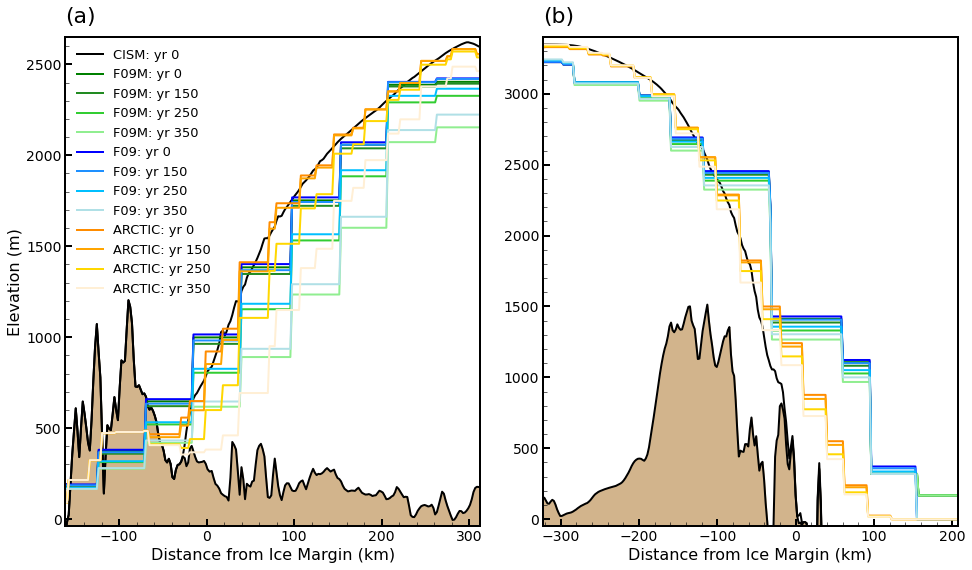

In [45]:
# Use CISM initial topography (in ARCTIC) as reference
fig = plt.figure(figsize = (16,9))
gs=GridSpec(1,2)
plt.rcParams['axes.titlepad'] = 14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

#-------------------------------------num1-------------------------------------
ax1 = plt.subplot(gs[0])

#plt.plot(kdist, kzraw, color='k', linewidth=2, label='GMTED')
plt.plot(kdist, ARCTIC_topg_yearly_0_k, color='k', linewidth=2, label='CISM: yr 0')
ax1.fill_between(kdist, -500, ARCTIC_topg_yearly_0_k, color='tan')
plt.plot(kdist, ARCTIC_thk_yearly_0_k+ARCTIC_topg_yearly_0_k, color='k', linewidth=2)
plt.plot(kdist, f09_PHIS_PI_Kt/g, color='green', linewidth=2, label='F09M: yr 0')
plt.plot(kdist, f09_PHIS_stab_Kt/g, color='forestgreen', linewidth=2, label='F09M: yr 150')
plt.plot(kdist, f09_PHIS_mid_Kt/g, color='limegreen', linewidth=2, label='F09M: yr 250')
plt.plot(kdist, f09_PHIS_end_Kt/g, color='lightgreen', linewidth=2, label='F09M: yr 350')

plt.plot(kdist, f09_nohacks_PHIS_PI_Kt/g, color='blue', linewidth=2, label='F09: yr 0')
plt.plot(kdist, f09_nohacks_PHIS_stab_Kt/g, color='dodgerblue', linewidth=2, label='F09: yr 150')
plt.plot(kdist, f09_nohacks_PHIS_mid_Kt/g, color='deepskyblue', linewidth=2, label='F09: yr 250')
plt.plot(kdist, f09_nohacks_PHIS_end_Kt/g, color='powderblue', linewidth=2, label='F09: yr 350')

plt.plot(kdist, ARCTIC_PHIS_PI_Kt/g, color='darkorange', linewidth=2, label='ARCTIC: yr 0')
plt.plot(kdist, ARCTIC_PHIS_stab_Kt/g, color='orange', linewidth=2, label='ARCTIC: yr 150')
plt.plot(kdist, ARCTIC_PHIS_mid_Kt/g, color='gold', linewidth=2, label='ARCTIC: yr 250')
plt.plot(kdist, ARCTIC_PHIS_end_Kt/g, color='papayawhip', linewidth=2, label='ARCTIC: yr 350')

ax1.set_xlim([kdist[0], kdist[-1]])
ax1.set_ylim([-40, 2650])
ax1.set_xlabel('Distance from Ice Margin (km)', fontsize = 16)
ax1.set_ylabel('Elevation (m)', fontsize = 16)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")
ax1.tick_params(labelsize=14)
plt.title('(a)', fontsize=22, loc='left')

ax1.legend(loc = 'best', frameon = False, prop={'size':13})

#-------------------------------------num2-------------------------------------
ax2 = plt.subplot(gs[1])

#plt.plot(sdist, szraw, color='k', linewidth=2, label='GMTED')
plt.plot(sdist, ARCTIC_topg_yearly_0_s, color='k', linewidth=2, label='CISM: yr 0')
ax2.fill_between(sdist, -500, ARCTIC_topg_yearly_0_s, color='tan')
plt.plot(sdist, ARCTIC_thk_yearly_0_s+ARCTIC_topg_yearly_0_s, color='k', linewidth=2)
plt.plot(sdist, f09_PHIS_PI_St/g, color='green', linewidth=2, label='F09M: yr 0')
plt.plot(sdist, f09_PHIS_stab_St/g, color='forestgreen', linewidth=2, label='F09M: yr 150')
plt.plot(sdist, f09_PHIS_mid_St/g, color='limegreen', linewidth=2, label='F09M: yr 250')
plt.plot(sdist, f09_PHIS_end_St/g, color='lightgreen', linewidth=2, label='F09M: yr 350')

plt.plot(sdist, f09_nohacks_PHIS_PI_St/g, color='blue', linewidth=2, label='F09: yr 0')
plt.plot(sdist, f09_nohacks_PHIS_stab_St/g, color='dodgerblue', linewidth=2, label='F09: yr 150')
plt.plot(sdist, f09_nohacks_PHIS_mid_St/g, color='deepskyblue', linewidth=2, label='F09: yr 250')
plt.plot(sdist, f09_nohacks_PHIS_end_St/g, color='powderblue', linewidth=2, label='F09: yr 350')

plt.plot(sdist, ARCTIC_PHIS_PI_St/g, color='darkorange', linewidth=2, label='ARCTIC: yr 0')
plt.plot(sdist, ARCTIC_PHIS_stab_St/g, color='orange', linewidth=2, label='ARCTIC: yr 150')
plt.plot(sdist, ARCTIC_PHIS_mid_St/g, color='gold', linewidth=2, label='ARCTIC: yr 250')
plt.plot(sdist, ARCTIC_PHIS_end_St/g, color='papayawhip', linewidth=2, label='ARCTIC: yr 350')

ax2.set_xlim([sdist[0], sdist[-1]])
ax2.set_ylim([-50, 3400])
ax2.set_xlabel('Distance from Ice Margin (km)', fontsize = 16)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")
ax2.tick_params(labelsize=14)
plt.title('(b)', fontsize=22, loc='left')


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.13)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Transect_elevation_K_S_CISM.png', dpi=300, bbox_inches='tight', facecolor='w', transparent = False)

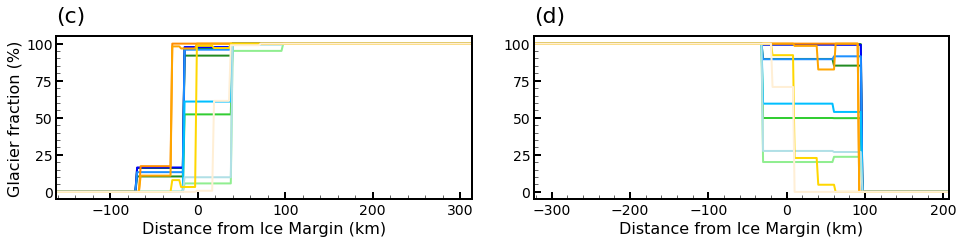

In [89]:
# Add glacier fraction
fig = plt.figure(figsize = (16,3))
gs=GridSpec(1,2)
plt.rcParams['axes.titlepad'] = 14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

#-------------------------------------num1-------------------------------------
ax1 = plt.subplot(gs[0])

plt.plot(kdist, f09_glacier_frac_PI_Kt, color='green', linewidth=2, label='F09M: yr 0')
plt.plot(kdist, f09_glacier_frac_stab_Kt, color='forestgreen', linewidth=2, label='F09M: yr 150')
plt.plot(kdist, f09_glacier_frac_mid_Kt, color='limegreen', linewidth=2, label='F09M: yr 250')
plt.plot(kdist, f09_glacier_frac_end_Kt, color='lightgreen', linewidth=2, label='F09M: yr 350')

plt.plot(kdist, f09_nohacks_glacier_frac_PI_Kt, color='blue', linewidth=2, label='F09: yr 0')
plt.plot(kdist, f09_nohacks_glacier_frac_stab_Kt, color='dodgerblue', linewidth=2, label='F09: yr 150')
plt.plot(kdist, f09_nohacks_glacier_frac_mid_Kt, color='deepskyblue', linewidth=2, label='F09: yr 250')
plt.plot(kdist, f09_nohacks_glacier_frac_end_Kt, color='powderblue', linewidth=2, label='F09: yr 350')

plt.plot(kdist, ARCTIC_glacier_frac_PI_Kt, color='darkorange', linewidth=2, label='ARCTIC: yr 0')
plt.plot(kdist, ARCTIC_glacier_frac_stab_Kt, color='orange', linewidth=2, label='ARCTIC: yr 150')
plt.plot(kdist, ARCTIC_glacier_frac_mid_Kt, color='gold', linewidth=2, label='ARCTIC: yr 250')
plt.plot(kdist, ARCTIC_glacier_frac_end_Kt, color='papayawhip', linewidth=2, label='ARCTIC: yr 350')

ax1.set_xlim([kdist[0], kdist[-1]])
ax1.set_ylim([-5, 105])
ax1.set_xlabel('Distance from Ice Margin (km)', fontsize = 16)
ax1.set_ylabel('Glacier fraction (%)', fontsize = 16)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction="in")
ax1.tick_params(which='minor', length=4, direction="in")
ax1.tick_params(labelsize=14)
plt.title('(c)', fontsize=22, loc='left')

#ax1.legend(loc = 'best', frameon = False, prop={'size':13})

#-------------------------------------num2-------------------------------------
ax2 = plt.subplot(gs[1])

plt.plot(sdist, f09_glacier_frac_PI_St, color='green', linewidth=2, label='F09M: yr 0')
plt.plot(sdist, f09_glacier_frac_stab_St, color='forestgreen', linewidth=2, label='F09M: yr 150')
plt.plot(sdist, f09_glacier_frac_mid_St, color='limegreen', linewidth=2, label='F09M: yr 250')
plt.plot(sdist, f09_glacier_frac_end_St, color='lightgreen', linewidth=2, label='F09M: yr 350')

plt.plot(sdist, f09_nohacks_glacier_frac_PI_St, color='blue', linewidth=2, label='F09: yr 0')
plt.plot(sdist, f09_nohacks_glacier_frac_stab_St, color='dodgerblue', linewidth=2, label='F09: yr 150')
plt.plot(sdist, f09_nohacks_glacier_frac_mid_St, color='deepskyblue', linewidth=2, label='F09: yr 250')
plt.plot(sdist, f09_nohacks_glacier_frac_end_St, color='powderblue', linewidth=2, label='F09: yr 350')

plt.plot(sdist, ARCTIC_glacier_frac_PI_St, color='darkorange', linewidth=2, label='ARCTIC: yr 0')
plt.plot(sdist, ARCTIC_glacier_frac_stab_St, color='orange', linewidth=2, label='ARCTIC: yr 150')
plt.plot(sdist, ARCTIC_glacier_frac_mid_St, color='gold', linewidth=2, label='ARCTIC: yr 250')
plt.plot(sdist, ARCTIC_glacier_frac_end_St, color='papayawhip', linewidth=2, label='ARCTIC: yr 350')

ax2.set_xlim([sdist[0], sdist[-1]])
ax2.set_ylim([-5, 105])
ax2.set_xlabel('Distance from Ice Margin (km)', fontsize = 16)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction="in")
ax2.tick_params(which='minor', length=4, direction="in")
ax2.tick_params(labelsize=14)
plt.title('(d)', fontsize=22, loc='left')


plt.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    wspace=0.15,
                    hspace=0.13)

plt.savefig(home_dir+'dynamic_GrIS/github/plot/Transect_glacier_frac_K_S.png', dpi=300, bbox_inches='tight', facecolor='w', transparent = False)

## Calculate SMB along the transects to get the ELA

### Read data

In [25]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_RAIN_1pctCO2_yearly.nc')['RAIN'][:140]
f09_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_SNOW_1pctCO2_yearly.nc')['SNOW'][:140]
f09_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:140]
f09_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:140]
f09_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'][:140]
f09_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:140]

# 4xCO2
f09_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_RAIN_4xext_yearly.nc')['RAIN']
f09_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_SNOW_4xext_yearly.nc')['SNOW']
f09_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
f09_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
f09_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
f09_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09muntjewerf/f09_QRUNOFF_4xext_yearly.nc')['QRUNOFF']

# Combine
f09_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_1pctCO2_RAIN_yearly, f09_4xext_RAIN_yearly], dim='time')
f09_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_1pctCO2_SNOW_yearly, f09_4xext_SNOW_yearly], dim='time')
f09_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_1pctCO2_QICE_MELT_yearly, f09_4xext_QICE_MELT_yearly], dim='time')
f09_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_1pctCO2_QSNOMELT_yearly, f09_4xext_QSNOMELT_yearly], dim='time')
f09_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([f09_1pctCO2_QFLX_EVAP_TOT_yearly, f09_4xext_QFLX_EVAP_TOT_yearly], dim='time')
f09_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_1pctCO2_QRUNOFF_yearly, f09_4xext_QRUNOFF_yearly], dim='time')

In [26]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_RAIN_1pctCO2_yearly.nc')['RAIN'][:]
f09_nohacks_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_SNOW_1pctCO2_yearly.nc')['SNOW'][:]
f09_nohacks_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:]
f09_nohacks_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:]
f09_nohacks_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'][:]
f09_nohacks_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:]

# 4xext
f09_nohacks_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_RAIN_4xext_yearly.nc')['RAIN'][:]
f09_nohacks_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_SNOW_4xext_yearly.nc')['SNOW'][:]
f09_nohacks_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_yearly.nc')['QICE_MELT'][:]
f09_nohacks_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QSNOMELT_4xext_yearly.nc')['QSNOMELT'][:]
f09_nohacks_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT'][:]
f09_nohacks_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_QRUNOFF_4xext_yearly.nc')['QRUNOFF'][:]

# Combine
f09_nohacks_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_nohacks_1pctCO2_RAIN_yearly, f09_nohacks_4xext_RAIN_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_nohacks_1pctCO2_SNOW_yearly, f09_nohacks_4xext_SNOW_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_nohacks_1pctCO2_QICE_MELT_yearly, f09_nohacks_4xext_QICE_MELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_nohacks_1pctCO2_QSNOMELT_yearly, f09_nohacks_4xext_QSNOMELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([f09_nohacks_1pctCO2_QFLX_EVAP_TOT_yearly, f09_nohacks_4xext_QFLX_EVAP_TOT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_nohacks_1pctCO2_QRUNOFF_yearly, f09_nohacks_4xext_QRUNOFF_yearly], dim='time')

In [27]:
## ARCTIC
# 1pctCO2
ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] 
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] 
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'] 
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']
ARCTIC_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']
ARCTIC_lon = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_lat.nc')['lat']

# 4xext
ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN']
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW']
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
ARCTIC_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
ARCTIC_4xext_PHIS_yearly = xr.open_dataset(home_dir+'dynamic_GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
ARCTIC_1pctCO2_4xext_RAIN_yearly = xr.concat([ARCTIC_1pctCO2_RAIN_yearly, ARCTIC_4xext_RAIN_yearly], dim='time')
ARCTIC_1pctCO2_4xext_SNOW_yearly = xr.concat([ARCTIC_1pctCO2_SNOW_yearly, ARCTIC_4xext_SNOW_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([ARCTIC_1pctCO2_QICE_MELT_yearly, ARCTIC_4xext_QICE_MELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([ARCTIC_1pctCO2_QSNOMELT_yearly, ARCTIC_4xext_QSNOMELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly, ARCTIC_4xext_QFLX_EVAP_TOT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([ARCTIC_1pctCO2_QRUNOFF_yearly, ARCTIC_4xext_QRUNOFF_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PHIS_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_yearly, ARCTIC_4xext_PHIS_yearly], dim='time')

In [28]:
## Calculate SMB
f09_1pctCO2_4xext_smb_yearly = f09_1pctCO2_4xext_RAIN_yearly + f09_1pctCO2_4xext_SNOW_yearly - f09_1pctCO2_4xext_QRUNOFF_yearly - f09_1pctCO2_4xext_QFLX_EVAP_TOT_yearly

f09_nohacks_1pctCO2_4xext_smb_yearly = f09_nohacks_1pctCO2_4xext_RAIN_yearly + f09_nohacks_1pctCO2_4xext_SNOW_yearly - f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly - f09_nohacks_1pctCO2_4xext_QFLX_EVAP_TOT_yearly

ARCTIC_1pctCO2_4xext_smb_yearly = ARCTIC_1pctCO2_4xext_RAIN_yearly + ARCTIC_1pctCO2_4xext_SNOW_yearly - ARCTIC_1pctCO2_4xext_QRUNOFF_yearly - ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly

In [29]:
## Select
# end of PI (here use year 1 to approximate)
f09_smb_PI = f09_1pctCO2_4xext_smb_yearly[0,:,:]
f09_nohacks_smb_PI = f09_nohacks_1pctCO2_4xext_smb_yearly[0,:,:]
ARCTIC_smb_PI = ARCTIC_1pctCO2_4xext_smb_yearly[0,:]

# end of simulation (year 350)
f09_smb_end = f09_1pctCO2_4xext_smb_yearly[-1,:,:]
f09_nohacks_smb_end = f09_nohacks_1pctCO2_4xext_smb_yearly[-1,:,:]
ARCTIC_smb_end = ARCTIC_1pctCO2_4xext_smb_yearly[-1,:]

### Interp

In [30]:
## K transect
# f09
f09_smb_PI_Kt = kdist * 0
f09_smb_end_Kt = kdist * 0

for i in range(len(kdist)):
    f09_smb_PI_Kt[i] = f09_smb_PI.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_smb_end_Kt[i] = f09_smb_end.interp(lat=klat[i], lon=klon[i], method='nearest')

# f09 nohacks
f09_nohacks_smb_PI_Kt = kdist * 0
f09_nohacks_smb_end_Kt = kdist * 0

for i in range(len(kdist)):
    f09_nohacks_smb_PI_Kt[i] = f09_nohacks_smb_PI.interp(lat=klat[i], lon=klon[i], method='nearest')
    f09_nohacks_smb_end_Kt[i] = f09_nohacks_smb_end.interp(lat=klat[i], lon=klon[i], method='nearest')

In [31]:
## S transect
# f09
f09_smb_PI_St = sdist * 0
f09_smb_end_St = sdist * 0

for i in range(len(sdist)):
    f09_smb_PI_St[i] = f09_smb_PI.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_smb_end_St[i] = f09_smb_end.interp(lat=slat[i], lon=slon[i], method='nearest')

# f09 nohacks
f09_nohacks_smb_PI_St = sdist * 0
f09_nohacks_smb_end_St = sdist * 0

for i in range(len(kdist)):
    f09_nohacks_smb_PI_St[i] = f09_nohacks_smb_PI.interp(lat=slat[i], lon=slon[i], method='nearest')
    f09_nohacks_smb_end_St[i] = f09_nohacks_smb_end.interp(lat=slat[i], lon=slon[i], method='nearest')

In [32]:
# For ARCTIC K transect, masked the vars
ARCTIC_lat_lndgrid = ARCTIC_smb_PI * 0 + ARCTIC_lat.values
ARCTIC_lon_lndgrid = ARCTIC_smb_PI * 0 + ARCTIC_lon.values
ARCTIC_lat_Ksel = ARCTIC_lat_lndgrid.where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')
ARCTIC_lon_Ksel = ARCTIC_lon_lndgrid.where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')
ARCTIC_smb_PI_Ksel = ARCTIC_smb_PI.where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')
ARCTIC_smb_end_Ksel = ARCTIC_smb_end.where((ARCTIC_lat.values>=66)&(ARCTIC_lat.values<=67.5)).where((ARCTIC_lon.values>=305.5)&(ARCTIC_lon.values<=317)).dropna(dim='lndgrid')

In [33]:
## K transect
# PI
ARCTIC_smb_PI_Kt = kdist * 0
ARCTIC_PI_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_PI_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_smb_PI_Kt[i] = ARCTIC_smb_PI_Ksel[ARCTIC_PI_Ksel_dist.argmin()]

# end
ARCTIC_smb_end_Kt = kdist * 0
ARCTIC_end_Ksel_dist = ARCTIC_lon_Ksel * 0

for i in range(len(kdist)):
    for j in range(len(ARCTIC_lon_Ksel)):
        ARCTIC_end_Ksel_dist[j] = distance((klat[i], klon[i]), (ARCTIC_lat_Ksel[j], ARCTIC_lon_Ksel[j]))
    ARCTIC_smb_end_Kt[i] = ARCTIC_smb_end_Ksel[ARCTIC_end_Ksel_dist.argmin()]

In [34]:
# For ARCTIC S transect, masked the vars
ARCTIC_lat_Ssel = ARCTIC_lat_lndgrid.where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')
ARCTIC_lon_Ssel = ARCTIC_lon_lndgrid.where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')
ARCTIC_smb_PI_Ssel = ARCTIC_smb_PI.where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')
ARCTIC_smb_end_Ssel = ARCTIC_smb_end.where((ARCTIC_lat.values>=66.5)&(ARCTIC_lat.values<=71.5)).where((ARCTIC_lon.values>=322)&(ARCTIC_lon.values<=330.5)).dropna(dim='lndgrid')

In [35]:
## S transect
# PI
ARCTIC_smb_PI_St = sdist * 0
ARCTIC_PI_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_PI_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_smb_PI_St[i] = ARCTIC_smb_PI_Ssel[ARCTIC_PI_Ssel_dist.argmin()]

# end
ARCTIC_smb_end_St = sdist * 0
ARCTIC_end_Ssel_dist = ARCTIC_lon_Ssel * 0

for i in range(len(sdist)):
    for j in range(len(ARCTIC_lon_Ssel)):
        ARCTIC_end_Ssel_dist[j] = distance((slat[i], slon[i]), (ARCTIC_lat_Ssel[j], ARCTIC_lon_Ssel[j]))
    ARCTIC_smb_end_St[i] = ARCTIC_smb_end_Ssel[ARCTIC_end_Ssel_dist.argmin()]

### Plot and calculate

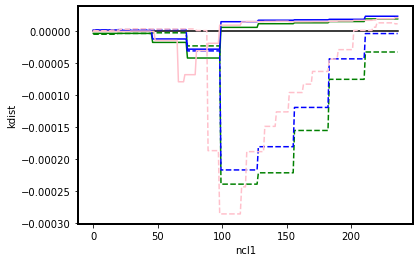

In [36]:
## K transect
# SMB
(f09_smb_PI_Kt * 0).plot(color='k');

f09_smb_PI_Kt.plot(color='g');
f09_smb_end_Kt.plot(color='g', linestyle='--');

f09_nohacks_smb_PI_Kt.plot(color='b');
f09_nohacks_smb_end_Kt.plot(color='b', linestyle='--');

ARCTIC_smb_PI_Kt.plot(color='pink');
ARCTIC_smb_end_Kt.plot(color='pink', linestyle='--');

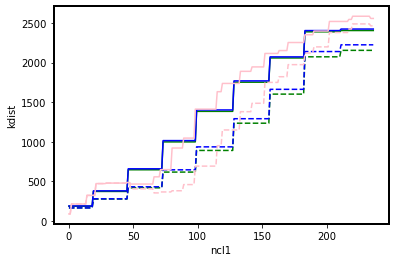

In [37]:
# Elevation
(f09_PHIS_PI_Kt/g).plot(color='g');
(f09_PHIS_end_Kt/g).plot(color='g', linestyle='--');

(f09_nohacks_PHIS_PI_Kt/g).plot(color='b');
(f09_nohacks_PHIS_end_Kt/g).plot(color='b', linestyle='--');

(ARCTIC_PHIS_PI_Kt/g).plot(color='pink');
(ARCTIC_PHIS_end_Kt/g).plot(color='pink', linestyle='--');

By the end of simulation, all the elevations along the K transect has negative SMB in the f09 runs

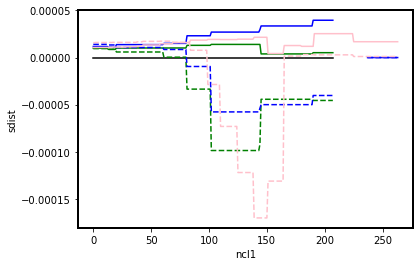

In [38]:
## S transect
(f09_smb_PI_St * 0).plot(color='k');

f09_smb_PI_St.plot(color='g');
f09_smb_end_St.plot(color='g', linestyle='--');

f09_nohacks_smb_PI_St.plot(color='b');
f09_nohacks_smb_end_St.plot(color='b', linestyle='--');

ARCTIC_smb_PI_St.plot(color='pink');
ARCTIC_smb_end_St.plot(color='pink', linestyle='--');

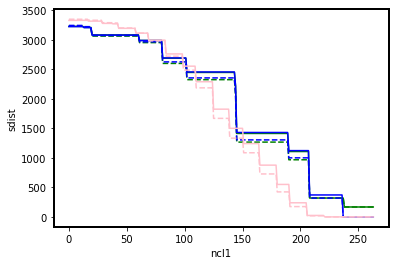

In [39]:
(f09_PHIS_PI_St/g).plot(color='g');
(f09_PHIS_end_St/g).plot(color='g', linestyle='--');

(f09_nohacks_PHIS_PI_St/g).plot(color='b');
(f09_nohacks_PHIS_end_St/g).plot(color='b', linestyle='--');

(ARCTIC_PHIS_PI_St/g).plot(color='pink');
(ARCTIC_PHIS_end_St/g).plot(color='pink', linestyle='--');

In [40]:
for i in range(len(f09_smb_end_St)):
    if f09_smb_end_St[i] < 0:
        print(f09_PHIS_end_St[i].values/g)
        break
for i in range(len(f09_nohacks_smb_end_St)):
    if f09_nohacks_smb_end_St[i] < 0:
        print(f09_nohacks_PHIS_end_St[i].values/g)
        break

2599.3084321487718
2625.140807538323
